The data is generated with the R script called 'MakeData'

In [1]:
#imports
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Load in some data

In [2]:
y_stream = pd.read_csv('y_stream.csv').values

S_mat_A = pd.read_csv('S_mat_A.csv').values
S_mat_B = pd.read_csv('S_mat_B.csv').values

y_hat_A = S_mat_A.dot(y_stream)
y_hat_B = S_mat_B.dot(y_stream)

## What is a trace and why is it useful

### It tells us the effective number of parameters for a certain class of models.

which is *extremely* useful. If two models explain the data equally well, then you'd prefer the simplier one, right? What if one is *much* simplier but explains the data only slightly less well? However you weigh these two, the tradeoff is hugely important. The trace allows us to quantify complexity and place it on one side of the scale.

### So what's that class of model?

It's any linear operator model. That is, any model for which the fitting procedure can be represented as:

$$
\hat{\mathbf{y}} = \mathbf{S}\mathbf{y}
$$

There are a some familiar models of this form:

1. In OLS regression with a design matrix $\mathbf{X}$:

$$
\mathbf{S} = \mathbf{X}\big(\mathbf{X}^T\mathbf{X}\big)^{-1}\mathbf{X}^T
$$

2. In ridge regression:

$$
\mathbf{S} = \mathbf{X}\big(\mathbf{X}^T\mathbf{X}+\lambda\mathbf{I}\big)^{-1}\mathbf{X}^T
$$

Where $\lambda$ determines our tradeoff between fitness and complexity.

3. Curve fitting with a natural cubic spline can be represented as:

$$
\hat{\mathbf{y}} = \mathbf{S}_\lambda\mathbf{y}
$$

where $\mathbf{S}_\lambda$ is called the smoothing matrix.

### How do you measure complexity?

Ignoring the specific examples above, how would you think about complexity in this general case? What if I gave you two 'models' represented as $\mathbf{S}^{(A)}$ and $\mathbf{S}^{(B)}$. What experiments would you run on them to determine which is more complex?

Well, vaguely, a complex model can fit a wider range of patterns than a simple one. In other words, if I gave a complex model some $\mathbf{y}$, it'll be better able to reproduce it than a simple one. Let's use this as a our working definition.

So let's experiment. I've invented a $\mathbf{y}$-generating function like this:

$$
y_i = g(\mathbf{x}_i) + \epsilon_i
$$

where $g(\cdot)$ is our 'true' function that I'm not telling you, $\mathbf{x}_i$ are our observations (that are baked into our models already) and $\epsilon_i$ is some mean-zero noise with variance $\sigma^2_\epsilon$. So we'll generated many $\mathbf{y}$'s from this, delivered them to our two models and observe the outgoing streams. So.. what's the first thing we might check? Well one idea is to look at one element of $\mathbf{y}$ - specifically, the scatter plot of inputs-outputs for that element.

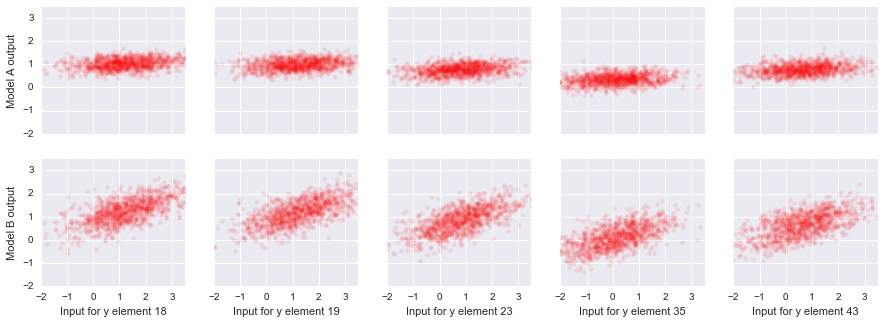

In [7]:
n_samp_i = 5
which_is = np.sort(np.random.choice(range(y_stream.shape[0]),n_samp_i,replace=False))

xlim = (-2,3.5)
ylim = (-2,3.5)

fig, axarr = plt.subplots(2, n_samp_i, sharex='col', sharey='row',figsize=(15,5))
for i, idx in enumerate(which_is):
    sns.regplot(y_stream[idx,:], y_hat_A[idx,:], ax=axarr[0, i],fit_reg=False,
                scatter_kws={'alpha':0.1,'color':'r'})
    sns.regplot(y_stream[idx,:], y_hat_B[idx,:], ax=axarr[1, i],fit_reg=False,
                scatter_kws={'alpha':0.1,'color':'r'})
    if i == 0:
        axarr[0, 0].set_ylabel('Model A output'.format(idx))
        axarr[1, 0].set_ylabel('Model B output'.format(idx))
    axarr[1, i].set_xlabel('Input for y element {}'.format(idx))
    axarr[1, i].set_xlim(xlim)
    axarr[1, i].set_ylim(ylim)
    axarr[0, i].set_xlim(xlim)
    axarr[0, i].set_ylim(ylim)

If there's anything to notice, it's that one model seems to be more *sensitive* to inputs. That sensitivity *is* exactly what it means to be more complex. A very 'sensitive-to-inputs' model is a model that reproduces it's inputs closely.

The idea is to measure that sensitivity with the slope of the best fit line.F1 So call that $\beta_i$. It would look like this:

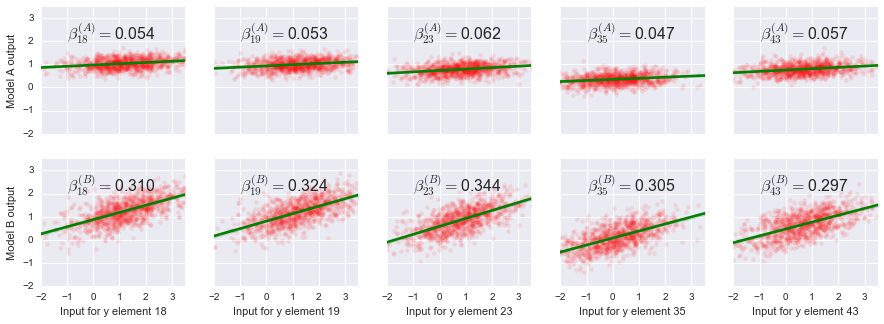

In [8]:
fig, axarr = plt.subplots(2, n_samp_i, sharex='col', sharey='row',figsize=(15,5))
for i, idx in enumerate(which_is):
    sns.regplot(y_stream[idx,:], y_hat_A[idx,:], ax=axarr[0, i],
                color='green',scatter_kws={'alpha':0.1,'color':'r'})
    sns.regplot(y_stream[idx,:], y_hat_B[idx,:], ax=axarr[1, i],
                color='green',scatter_kws={'alpha':0.1,'color':'r'})
    if i == 0:
        axarr[0, 0].set_ylabel('Model A output'.format(idx))
        axarr[1, 0].set_ylabel('Model B output'.format(idx))
    
    var_y = np.var(y_stream[idx,:])
    cov_A = np.cov(y_stream[idx,:],y_hat_A[idx,:])[0,1]
    cov_B = np.cov(y_stream[idx,:],y_hat_B[idx,:])[0,1]
    
    txt = r'$\beta^{(A)}_{i}=$' + str(cov_A/var_y)[:5]
    txt = txt.replace('i',str(idx))
    axarr[0, i].annotate(txt,xy=(0,0),xytext=(-1,2.1),fontsize=16)
    
    txt = r'$\beta^{(B)}_{i}=$' + str(cov_B/var_y)[:5]
    txt = txt.replace('i',str(idx))
    axarr[1, i].annotate(txt,xy=(0,0),xytext=(-1,2.1),fontsize=16)    
        
    axarr[1, i].set_xlabel('Input for y element {}'.format(idx))
    axarr[1, i].set_xlim(xlim)
    axarr[1, i].set_ylim(ylim)
    axarr[0, i].set_xlim(xlim)
    axarr[0, i].set_ylim(ylim)

Now on a per-element basis, we have a measure of complexity. But how would we combine these into a measure for the full model? Suppose both models yield the same input-output $\beta_i$'s, but the first model only applies to $\mathbf{y}$ vectors of length 10, whereas the second works for vectors of length 1,000? It's reasonable to say the second is 100x more complicated, yes? So let's make the model complexity the sum of these $\beta_i$'s:

$$
\textrm{Complexity}(\mathbf{S}) = \sum_i \beta_i
$$

Great, now we have a measure of model complexity. Unfortunately, it comes from the unrealistic world where I can sample $\mathbf{y}$'s repeatedly..

### How do you *actually* measure complexity?

Complexity is a function of the model, so we have should be able to estimate it from $\mathbf{S}$. Fortunately, we can write:

$$
\beta_i = \frac{\textrm{cov}(\hat{y}_i,y_i)}{\textrm{var}(y_i)} = \frac{\textrm{cov}(\hat{y}_i,y_i)}{\sigma^2_\epsilon}
$$

$\hat{y}_i$ is just a linear combination of $\mathbf{y}$, so:

$$
\begin{align}
\frac{\textrm{cov}(\hat{y}_i,y_i)}{\sigma^2_\epsilon} & = \frac{\textrm{cov}(s_{i1}y_1+s_{i2}y_2+\cdots+s_{iN}y_N,y_i)}{\sigma^2_\epsilon} \\ & = \frac{s_{ii}\textrm{var}(y_i)}{\sigma^2_\epsilon} \\ & = s_{ii}
\end{align}
$$

So for the full model:

$$
\textrm{Complexity}(\mathbf{S}) = \sum_i s_{ii} = \textrm{Trace}(\mathbf{S})
$$

And there we have it! The trace of our linear model is the complexity. This should make sense. It measures how much a model uses $y_i$ in it's recreation with $\hat{y}_i$.

So in the case of our two models:

$$
\textrm{Trace}(\mathbf{S}^{(A)}) = 5\\
\textrm{Trace}(\mathbf{S}^{(B)}) = 23 
$$

We can see this more directly if we look at their fits (for a randomly selected $\mathbf{y}$:

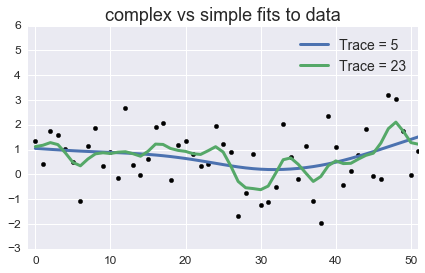

In [18]:
# pd.DataFrame({'x':range(y_stream.shape[0]),'y':y_stream[:,0]}).plot.scatter(x='x',y='y')
# plt.line(y_hat_A[:,0])

x = range(y_stream.shape[0])
y = y_stream[:,0]
fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(x, y, c='black')
plt.plot(x,y_hat_A[:,0],label='Trace = 5',linewidth=3)
plt.plot(x,y_hat_B[:,0],label='Trace = 23',linewidth=3)
plt.xlim(-1,51)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.title('complex vs simple fits to data',fontsize=18)
pass

### Place it on the scale

In general, we fit models by minimizing something like:

$$
\textrm{(fit to the data)} + \lambda\textrm{(model complexity)} 
$$

where $\lambda$ is some fitness-complexity trade off parameter. So we might choose the $\mathbf{S}$ that minimizes:

$$
(\mathbf{y} - \mathbf{S}\mathbf{y})^T(\mathbf{y} - \mathbf{S}\mathbf{y}) + \lambda\textrm{Trace}(\mathbf{S}) 
$$

This isn't typically how such objectives are written, but that's because if we know something specific about $\mathbf{S}$, we can simplify that Trace expression. (If you'd like to see for yourself, try the case for linear regression and use SVD on $\mathbf{S}$.

### Does this tell us anything else?

One extra thing I notice is.. the Trace($\cdot$) operator ignores most of the given matrix, so there's a lot that incur no complexity penality. That is to say, if you can figure out how to model $y_i$ with anything other than $y_i$ itself, you can do so without worrying about complexity.

-----------------------

If you'd like to know about this stuff, check out the Elements of Statistical Learning. That's where I got most of these ideas.


In [6]:
F1 You could technically have a model that has a greater sensitivity than 1, but that would be create complexity without improving a fit.

SyntaxError: invalid syntax (<ipython-input-6-65f5201c8e22>, line 1)